In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from skimage.transform import resize
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
import elasticdeform

In [2]:
from SYMPTOMM.external.DeLTA import data as DeLTA_data

In [3]:
X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/bent_noisematched_allsize_emptytrench/convolutions/*.tif"))
Y = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/bent_noisematched_allsize_emptytrench/masks/*.tif"))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [5]:
requires_resize = True
resize_shape = (256,64)
if requires_resize:
    Y = [resize(y,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None).astype(int) for y in tqdm(Y)]
    X = [resize(x,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]

100%|██████████| 7747/7747 [00:04<00:00, 1845.74it/s]


In [6]:
def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    #illumination_voodoo first:
    x = DeLTA_data.illumination_voodoo(x,np.random.choice([2,3,4]))
    elasdef_sigma = np.random.uniform(1,2.5)
    elasdef_points = np.random.choice([2,3])
    x = DeLTA_data.elasdef(x,sigma=elasdef_sigma,points=elasdef_points,order=1)
    y = DeLTA_data.elasdef(y,sigma=elasdef_sigma,points=elasdef_points,order=0)
    
    zoomshift_zoomlevel = np.random.uniform(1,1.1)
    zoomshift_shiftX = np.random.uniform(-0.05,0.1)
    zoomshift_shiftY = np.random.uniform(-0.05,0.1)
    x = DeLTA_data.zoomshift(x,zoomlevel = zoomshift_zoomlevel, shiftX = zoomshift_shiftX, shiftY = zoomshift_shiftY,order=0)
    y = DeLTA_data.zoomshift(y,zoomlevel = zoomshift_zoomlevel, shiftX = zoomshift_shiftX, shiftY = zoomshift_shiftY,order=0).astype(int)
    axis_norm = (0,1)   # normalize channels independently
    x = normalize(x,1,99.8,axis=axis_norm)
    y = fill_label_holes(y.astype(int))
    return x, y

In [7]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y.astype(int)) for y in tqdm(Y)]

100%|██████████| 7747/7747 [00:04<00:00, 1892.26it/s]


In [8]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.2 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 7747
- training:       6198
- validation:     1549


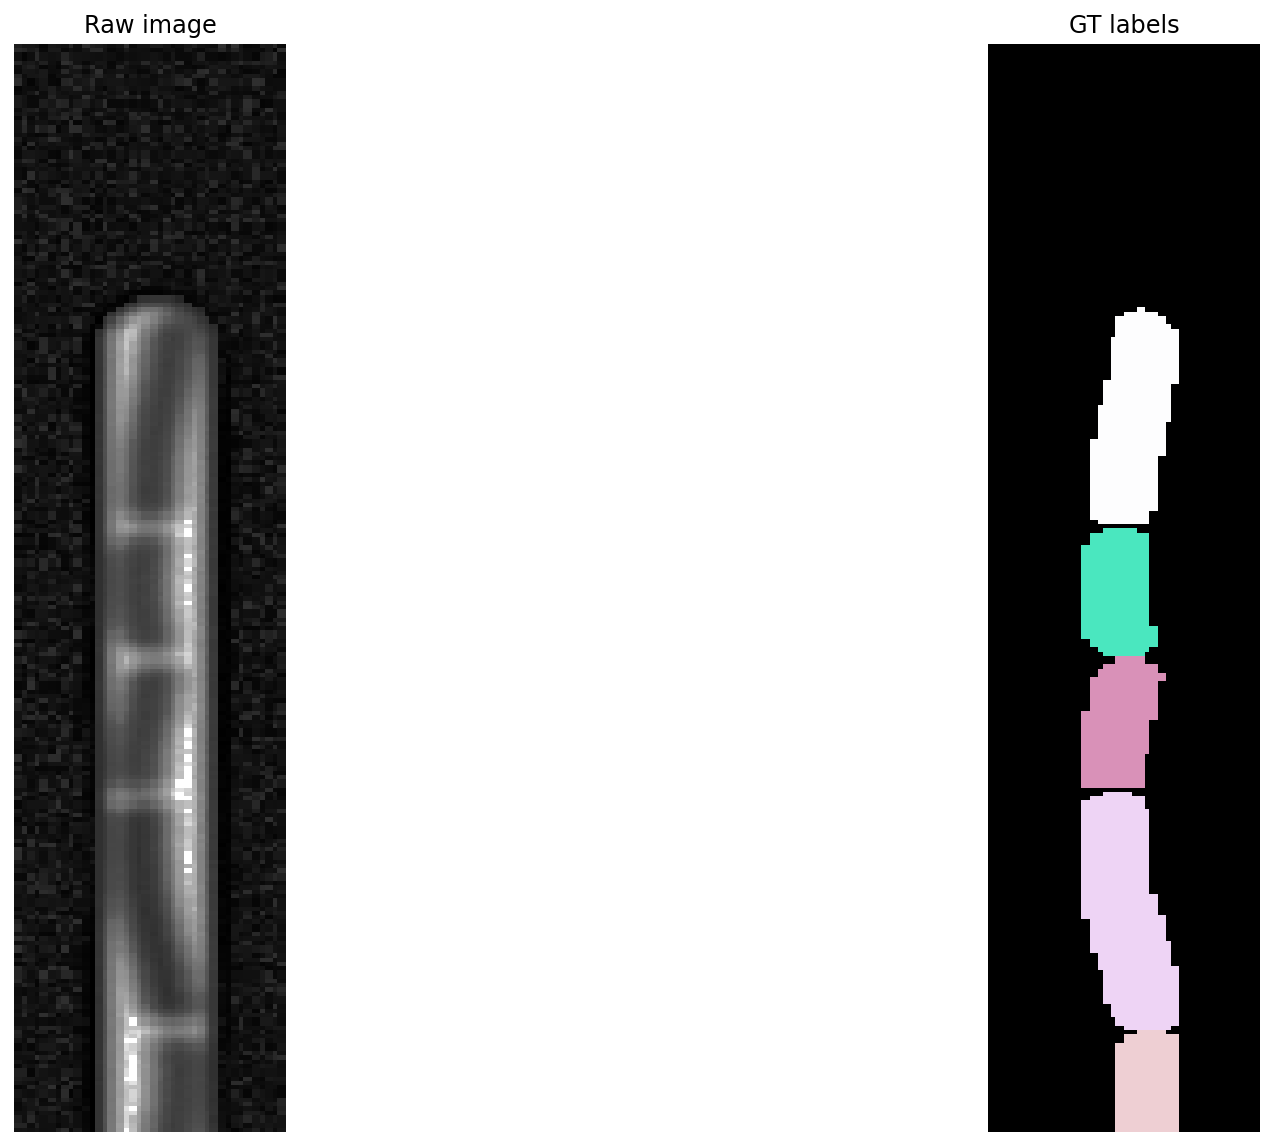

In [9]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [ ]:
np.random.seed(42)
data = StarDistData2D(X,Y,batch_size=9,n_rays=128,patch_size=X[i].shape,shape_completion=False,length=1)

In [ ]:
(img,), (prob,dist) = data[0]
dist, dist_mask = dist[...,:-1], dist[...,-1:]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
                    ['Input image','Object probability','Distance mask','Distance (0°)']):
    a.imshow(d[0,...,0],cmap=cm)
    a.set_title(s)
plt.tight_layout()
None;

In [ ]:
print(Config2D.__doc__)

In [ ]:
unet_n_depths = [6]
unet_activations = ["relu"]
unet_last_activations = ["sigmoid"]
train_epochs = 1000
for unet_n_depth in unet_n_depths:
    for unet_activation in unet_activations:
        for unet_last_activation in unet_last_activations:
            conf = Config2D(
                n_channel_in=n_channel, 
                train_shape_completion=False, 
                train_patch_size=resize_shape, 
                use_gpu=True,
                train_background_reg = 0.000001,
                train_learning_rate=0.0002,
                unet_batch_norm = True,
                unet_dropout=0.3,
                train_epochs=train_epochs,
                unet_n_depth=unet_n_depth,
                n_rays = 128,
                unet_activation = unet_activation,
                unet_last_activation = unet_last_activation
            )
            #print(conf)
            #vars(conf)
            model = StarDist2D(conf, name='stardist_no_shape_completion', basedir='/home/georgeos/Storage/Google Drive (Cambridge Univeristy)/SYMPTOMM_models/bent_noisematched_allsize_empty_und{}_una{}_unla{}_epc{}_aug'.format(unet_n_depth,unet_activation,unet_last_activation,train_epochs))

            model.train(X_trn,Y_trn,validation_data=(X_val,Y_val), augmenter=augmenter)

In [ ]:
/home/georgeos/Storage/Google Drive (Cambridge Univeristy)/SYMPTOMM_models

In [ ]:
unet_n_depths = [6]
unet_activations = ["relu"]
unet_last_activations = ["sigmoid"]
train_epochs = 1000
for unet_n_depth in unet_n_depths:
    for unet_activation in unet_activations:
        for unet_last_activation in unet_last_activations:
            conf = Config2D(
                n_channel_in=n_channel, 
                train_shape_completion=False, 
                train_patch_size=resize_shape, 
                use_gpu=True,
                train_background_reg = 0.000001,
                train_learning_rate=0.0002,
                unet_batch_norm = True,
                unet_dropout=0.3,
                train_epochs=train_epochs,
                unet_n_depth=unet_n_depth,
                n_rays = 128,
                unet_activation = unet_activation,
                unet_last_activation = unet_last_activation
            )
            #print(conf)
            #vars(conf)
            model = StarDist2D(conf, name='stardist_no_shape_completion', basedir='C:\\Users\\gh464\\Google Drive\\SYMPTOMM_models\\bent_noisematched_allsize_empty_und{}_una{}_unla{}_epc{}'.format(unet_n_depth,unet_activation,unet_last_activation,train_epochs))

            model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))